# 1. Import needed libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense, ReLU
from tensorflow.keras.layers import Embedding, BatchNormalization, Concatenate
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# 2. Read and Preprocessing data

### 2.1 Read data

In [6]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [51]:
train_df = pd.read_csv("/content/train.txt",
                 delimiter=';', header=None, names=['sentence','label'])

test_df = pd.read_csv("/content/test.txt",
                 delimiter=';', header=None, names=['sentence','label'])

val_df = pd.read_csv("/content/val.txt",
                 delimiter=';', header=None, names=['sentence','label'])

In [52]:
with open('/content/test.txt', 'r') as file:
    lines = file.readlines()
    print(lines[380])

Я чувствую, что страдания больше, чем я могу вынести; sadness



In [53]:
train_df

,sentence,label
0,Я не чувствовал себя униженным,sadness
1,Я могу перейти от чувства безнадежности к тако...,sadness
2,"Я хватаю минуту, чтобы опубликовать, я чувству...",anger
3,"Я всегда испытываю ностальгию по камину, я буд...",love
4,Я чувствую себя ворчливым,anger
...,...,...
15997,У меня было очень короткое время в мешке с фас...,sadness
15998,"Теперь я поворачиваюсь, и мне жалко, что я все...",sadness
15999,В целом я чувствую себя сильным и хорошим,joy
16000,"Я чувствую, что это был такой грубый комментар...",anger


In [54]:
train_df['label'].unique()

array([' sadness', ' anger', ' love', ' suprise', ' fear', ' joy', nan],
      dtype=object)

In [77]:
train_df = train_df.dropna(subset=['label'])

In [78]:
test_df = train_df.dropna(subset=['label'])
val_df = train_df.dropna(subset=['label'])

In [74]:
train_df['label'].unique()

array([' sadness', ' anger', ' love', ' suprise', ' fear', ' joy'],
      dtype=object)

In [55]:
train_df.label.value_counts()

 joy        5321
 sadness    4650
 anger      2146
 fear       1927
 love       1294
 suprise     571
Name: label, dtype: int64

In [56]:
test_df.label.value_counts()

 joy        687
 sadness    582
 anger      275
 fear       224
 love       159
 suprise     66
Name: label, dtype: int64

In [57]:
val_df.label.value_counts()

 joy        702
 sadness    544
 anger      274
 fear       212
 love       178
 suprise     81
Name: label, dtype: int64

### 2.2 Split data into X, y

In [79]:
tr_text = train_df['sentence']
tr_label = train_df['label']

val_text = val_df['sentence']
val_label = val_df['label']

ts_text = test_df['sentence']
ts_label = test_df['label']

### 2.3 Encoding

In [80]:
encoder = LabelEncoder()
tr_label = encoder.fit_transform(tr_label)
val_label = encoder.transform(val_label)
ts_label = encoder.transform(ts_label)

### 2.4 Text preprocessing

In [81]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(tr_text)

sequences = tokenizer.texts_to_sequences(tr_text)

tr_x = pad_sequences(sequences, maxlen=50)
tr_y = to_categorical(tr_label)

sequences = tokenizer.texts_to_sequences(val_text)
val_x = pad_sequences(sequences, maxlen=50)
val_y = to_categorical(val_label)

sequences = tokenizer.texts_to_sequences(ts_text)
ts_x = pad_sequences(sequences, maxlen=50)
ts_y = to_categorical(ts_label)

# 3. Building deep learning model

In [82]:
max_words = 10000
max_len = 50
embedding_dim = 64

### 3.1 Model architecture

In [83]:
# Branch 1
branch1 = Sequential()
branch1.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch1.add(Conv1D(64, 3, padding='same', activation='relu'))
branch1.add(BatchNormalization())
branch1.add(ReLU())
branch1.add(Dropout(0.5))
branch1.add(GlobalMaxPooling1D())

# Branch 2
branch2 = Sequential()
branch2.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch2.add(Conv1D(64, 3, padding='same', activation='relu'))
branch2.add(BatchNormalization())
branch2.add(ReLU())
branch2.add(Dropout(0.5))
branch2.add(GlobalMaxPooling1D())

concatenated = Concatenate()([branch1.output, branch2.output])

hid_layer = Dense(128, activation='relu')(concatenated)
dropout = Dropout(0.5)(hid_layer)
output_layer = Dense(6, activation='softmax')(dropout)

model = Model(inputs=[branch1.input, branch2.input], outputs=output_layer)

### 3.2 Compile model

In [84]:
model.compile(optimizer='adamax',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 embedding_6_input (InputLa  [(None, 50)]                 0         []                            
 yer)                                                                                             
                                                                                                  
 embedding_7_input (InputLa  [(None, 50)]                 0         []                            
 yer)                                                                                             
                                                                                                  
 embedding_6 (Embedding)     (None, 50, 64)               640000    ['embedding_6_input[0][0]']   
                                                                                            

### 3.3 Traning the model

In [85]:
batch_size = 128
epochs = 25
history = model.fit([tr_x, tr_x], tr_y, epochs=epochs, batch_size=batch_size,
                    validation_data=([val_x, val_x], val_y))

Epoch 1/25
125/125 [==============================] - 17s 106ms/step - loss: 1.7988 - accuracy: 0.3047 - precision_3: 0.3220 - recall_3: 0.0671 - val_loss: 1.7658 - val_accuracy: 0.3448 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/25
125/125 [==============================] - 12s 97ms/step - loss: 1.5925 - accuracy: 0.3528 - precision_3: 0.4867 - recall_3: 0.0436 - val_loss: 1.7415 - val_accuracy: 0.4162 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 12s 92ms/step - loss: 1.5415 - accuracy: 0.3929 - precision_3: 0.5803 - recall_3: 0.0761 - val_loss: 1.6957 - val_accuracy: 0.4776 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 11s 92ms/step - loss: 1.4765 - accuracy: 0.4250 - precision_3: 0.6592 - recall_3: 0.1419 - val_loss: 1.5992 - val_accuracy: 0.5159 - val_precision_3: 1.0000 - val_recall_3: 0.0016
Epoch 5/25
125/125 [===================

# 4. Evaluation and Visullize results

### 4.1 Evaluate the model

In [86]:
(loss, accuracy, percision, recall) = model.evaluate([ts_x, ts_x], ts_y)
print(f'Loss: {round(loss, 2)}, Accuracy: {round(accuracy, 2)}, Precision: {round(percision, 2)}, Recall: {round(recall, 2)}')

498/498 [==============================] - 2s 4ms/step - loss: 0.0881 - accuracy: 0.9850 - precision_3: 0.9902 - recall_3: 0.9754
Loss: 0.09, Accuracy: 0.98, Precision: 0.99, Recall: 0.98


In [87]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision_3', 'recall_3', 'val_loss', 'val_accuracy', 'val_precision_3', 'val_recall_3'])

### 4.2 Visullize results

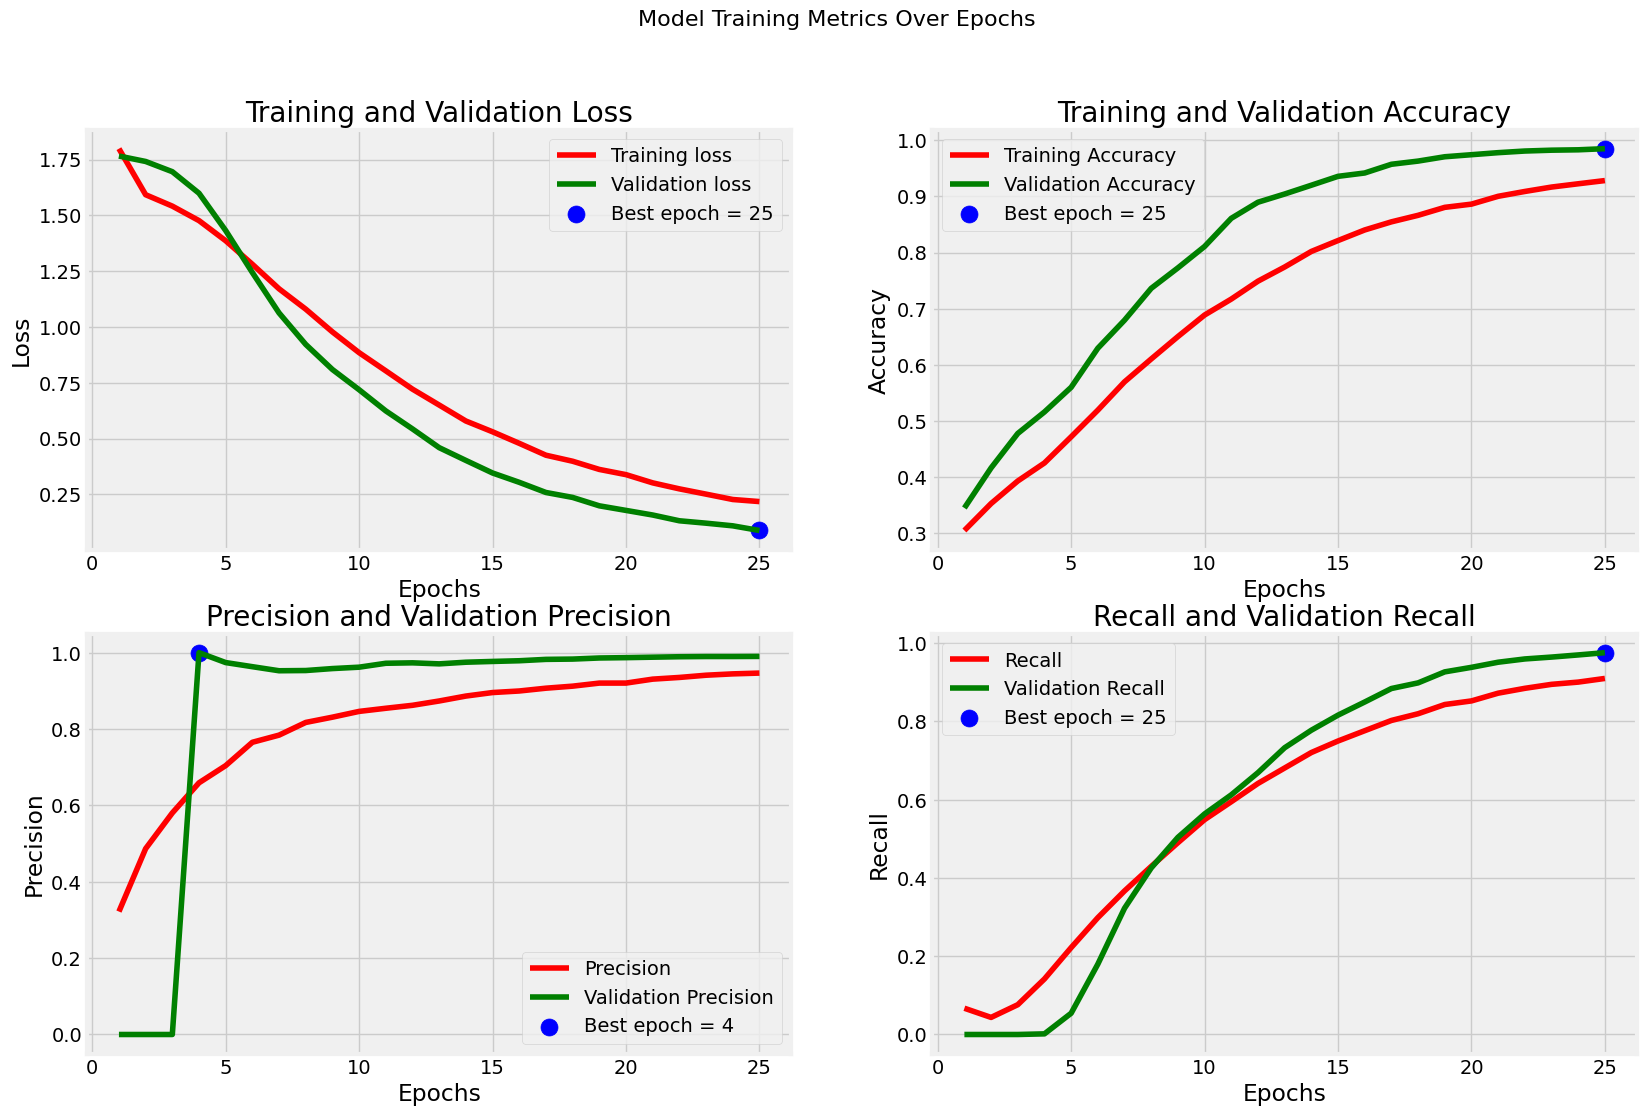

In [89]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
tr_per = history.history['precision_3']
tr_recall = history.history['recall_3']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
val_per = history.history['val_precision_3']
val_recall = history.history['val_recall_3']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]


Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [90]:
y_true=[]
for i in range(len(ts_y)):
    x = np.argmax(ts_y[i])
    y_true.append(x)

In [91]:
preds = model.predict([ts_x, ts_x])
y_pred = np.argmax(preds, axis=1)
y_pred

498/498 [==============================] - 2s 4ms/step


array([4, 4, 0, ..., 2, 0, 4])

<Axes: >

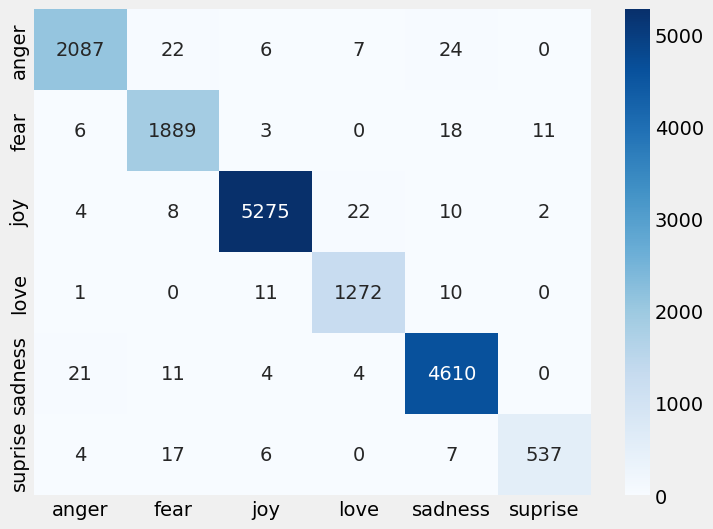

In [92]:
plt.figure(figsize=(8,6))
emotions = {0: 'anger', 1: 'fear', 2: 'joy', 3:'love', 4:'sadness', 5:'suprise'}
emotions = list(emotions.values())
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)

In [93]:
clr = classification_report(y_true, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2146
           1       0.97      0.98      0.98      1927
           2       0.99      0.99      0.99      5321
           3       0.97      0.98      0.98      1294
           4       0.99      0.99      0.99      4650
           5       0.98      0.94      0.96       571

    accuracy                           0.98     15909
   macro avg       0.98      0.98      0.98     15909
weighted avg       0.98      0.98      0.98     15909



# 5. Save model

In [ ]:
import pickle

# tokenizer file for prediction
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

# encoder file for classes
with open('encoder.pkl', 'wb') as encoder_file:
    pickle.dump(encoder, encoder_file)

# Keras Model
model.save('nlp_model.keras')

# H5 Model
model.save('nlp_model.h5')